In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import dataset
df = pd.read_csv('./dataset/230322_OlderPredictTc_data_thermal.csv')

print("Number unique participants before exclustion:", len(df['id_all'].unique()))

# Select only time > 0
df = df[df.time > 0]
# Select only people >= 60
df = df[df.age >= 60]

# Remove ID 26 (id_all = 93) from heatwave 2 (hot) due to incomplete data (only ran until 469 minutes instead of full 480)
condition_mask = (df['study'] == 'heatwave 2 (indoor)') & (df['condition'] == 'hot')
df = df[~((df['id'] == 26) & condition_mask)]

print("Number unique participants after exclustion:", len(df['id_all'].unique()))

Number unique participants before exclustion: 96
Number unique participants after exclustion: 76


In [2]:
from sklearn.model_selection import KFold
import numpy as np

# Get unique 'id_all' values
unique_ids = df['id_all'].unique()

# Number of folds
n_splits = 4

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=453090) # random seed for reproducibility

folds = []

# Split the data into folds
for train_index, test_index in kf.split(unique_ids):
    test_ids = unique_ids[test_index]
    folds.append(test_ids.tolist())

print(folds)

[[24, 28, 43, 50, 57, 62, 66, 68, 71, 72, 75, 79, 83, 86, 90, 93, 94, 95, 97], [22, 25, 26, 32, 34, 35, 45, 48, 54, 55, 59, 67, 69, 70, 74, 76, 85, 91, 98], [21, 27, 30, 37, 42, 46, 47, 49, 53, 61, 63, 65, 73, 78, 81, 82, 87, 92, 96], [23, 29, 33, 36, 38, 39, 40, 41, 44, 52, 56, 58, 60, 64, 77, 80, 84, 88, 89]]


In [3]:
folds_data = []

for fold in folds:
    data = df[df['id_all'].isin(fold)]
    folds_data.append(data)

print(folds_data)

[                        study  id  id_all  htn  t2d  female  age  height  \
13164  heatwave 1 (prolonged)  24      24    0    0       1   70     170   
13165  heatwave 1 (prolonged)  24      24    0    0       1   70     170   
13166  heatwave 1 (prolonged)  24      24    0    0       1   70     170   
13167  heatwave 1 (prolonged)  24      24    0    0       1   70     170   
13168  heatwave 1 (prolonged)  24      24    0    0       1   70     170   
...                       ...  ..     ...  ...  ...     ...  ...     ...   
98700     heatwave 2 (indoor)  36      97    1    1       1   73     160   
98701     heatwave 2 (indoor)  36      97    1    1       1   73     160   
98702     heatwave 2 (indoor)  36      97    1    1       1   73     160   
98703     heatwave 2 (indoor)  36      97    1    1       1   73     160   
98704     heatwave 2 (indoor)  36      97    1    1       1   73     160   

        mass   bmi  ...  ta_set  rh_set        ta abs_humidity   metrate  \
13164  69.

In [4]:
counts = []

for data in folds_data:
    count = data.groupby(['study', 'condition'])['id_all'].nunique()
    counts.append(count)

result = pd.concat(counts, axis=1)
result.columns = ['Fold 1 Count', 'Fold 2 Count', 'Fold 3 Count', 'Fold 4 Count']

result

Fold 1 Count  Fold 2 Count  Fold 3 Count  \
study                  condition                                             
heatwave 1 (prolonged) hot                   9            11             9   
heatwave 2 (indoor)    cool                  4             4             4   
                       hot                  10            10             8   
                       temp                  4             4             4   
                       warm                 11            10             9   
heatwave 3 (cooling)   hot                   3             5             5   

                                  Fold 4 Count  
study                  condition                
heatwave 1 (prolonged) hot                  10  
heatwave 2 (indoor)    cool                  4  
                       hot                   7  
                       temp                  4  
                       warm                  7  
heatwave 3 (cooling)   hot                   6

/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_29000/1643705997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data.loc[:, 'height_m'] = fold_data['height'] / 100
/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_29000/1643705997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold_data.loc[:, 'height_m'] = fold_data['height'] / 100
/var/folders/8q/byh6pjkx74d7p_crfrzgdpbd2xgt0t/T/ipykernel_29000/1643705997.py:11: SettingWithCopyWarning: 
A value is trying to be set on a

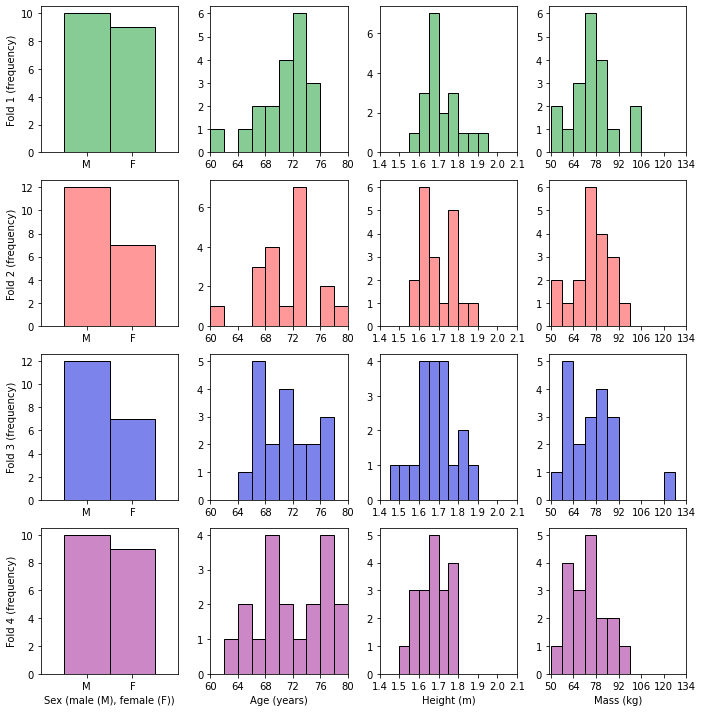

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

# sns.set(style="whitegrid")
colors = ['#87CC94', '#FF9999', '#7c84eb', '#cc87c6']

# Calculate height in meters for each fold
for fold_data in folds_data:
    fold_data.loc[:, 'height_m'] = fold_data['height'] / 100

# Remove duplicates based on 'id_all' column for each fold
folds_dist = [data.drop_duplicates(subset='id_all') for data in folds_data]

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

variables = ['female', 'age', 'height_m', 'mass']
labels = ['Sex (male (M), female (F))', 'Age (years)', 'Height (m)', 'Mass (kg)']

# Set common labels - only for the first column
for i in range(4):
    axs[i, 0].set_ylabel(f'Fold {i+1} (frequency)')

for j, var in enumerate(variables):
    # Determine global min/max for consistent binning
    combined_dist = pd.concat(folds_dist)
    min_val = combined_dist[var].min()
    max_val = combined_dist[var].max()

    if var == 'female':
        # For binary variables, set bins explicitly
        bins = [0, 0.5, 1]  # Define bin edges to get two bars centered at 0 and 1
        bin_width = 0.5  # Fixed bin width for categorical

        # Calculate common x-limits
        combined_dist = pd.concat(folds_dist)
        min_val = combined_dist[var].min()
        max_val = combined_dist[var].max()
        xlim_min = min_val - bin_width / 2
        xlim_max = max_val + bin_width / 2

    else:
        # Determine tick spacing based on variable
        if var == 'height_m':
            tick_spacing = 0.1
            xticks = np.arange(1.4, 2.0 + tick_spacing, tick_spacing)
            bin_width = tick_spacing / 2
            bins = np.arange(1.4, 2.0 + bin_width, bin_width)
        elif var == 'mass':
            tick_spacing = 14
            xticks = np.arange(50, 134 + tick_spacing, tick_spacing)
            bin_width = tick_spacing / 2
            bins = np.arange(50, 134 + bin_width, bin_width)
        elif var == 'age':
            tick_spacing = 4
            xticks = np.arange(60, 80 + tick_spacing, tick_spacing)
            bin_width = tick_spacing / 2
            bins = np.arange(60, 80 + bin_width, bin_width)

        xlim_min = min_val
        xlim_max = max_val

    for i, fold_dist in enumerate(folds_dist):
        # Fold data histogram, now with explicit bins
        axs[i, j].hist(fold_dist[var], bins=bins, color=colors[i % len(colors)], alpha=1, edgecolor='black')

        # Set x labels (only for the last row)
        if i == 3:
            axs[i, j].set_xlabel(labels[j])

        # Set x limits (using calculated limits for consistency)
        for k in range(4):
            axs[k, j].set_xlim(xlim_min, xlim_max)

        # Set x ticks (optimized for clarity)
        if var == 'height_m':
            for k in range(4):
                axs[k, j].set_xticks(xticks)
        elif var == 'mass':
            for k in range(4):
                axs[k, j].set_xticks(xticks)
        elif var == 'female':
            for k in range(4):
                axs[k, j].set_xticks([0.25, 0.75]) # Centering ticks for clarity
                axs[k, j].set_xticklabels(['M', 'F'])
        elif var == 'age':
            for k in range(4):
                axs[k, j].set_xticks(xticks)

plt.tight_layout()
plt.savefig("figures/data_distribution_folds.pdf", format='pdf')
plt.show()